<a href="https://colab.research.google.com/github/erick007bon/Ecuador-crime-prediction/blob/main/Proyecto_Inundaciones_Ecuador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación del Riesgo de Inundación por Parroquia en Ecuador

 Información del Proyecto

**Universidad:** Universidad de Guayaquil  
**Materia:** Técnicas de Aprendizaje Automático  
**Profesor:** Eduardo Flor Calva  
**Estudiante:** Erick Reinaldo Flores Zambrano  
**Fecha:** Enero 2026  

---

 Objetivo

Diseñar e implementar un modelo de clasificación supervisada que permita categorizar parroquias según su nivel de riesgo de inundación (Bajo/Medio/Alto), comparando el desempeño de distintos modelos y justificando técnicamente los resultados obtenidos.

---

 Variables del Estudio

### Variables Predictoras (X):
1. **precipitacion_mm** - Precipitación decadal (cada 10 días) en milímetros
2. **precipitacion_normalizada** - Z-score de la precipitación (variable derivada obligatoria)
3. **latitud** - Coordenada geográfica (grados decimales)
4. **longitud** - Coordenada geográfica (grados decimales)
5. **tipo_zona** - Clasificación urbana (1) o rural (0)
6. **altitud_media** - Altitud estimada en metros sobre el nivel del mar

### Variable Objetivo (Y):
- **nivel_riesgo** - Clasificación: Bajo / Medio / Alto

---

Modelos a Implementar

1. **Regresión Logística** (modelo base obligatorio)
2. **Árbol de Decisión**
3. **Random Forest** (con GridSearchCV)

---

Métricas de Evaluación

- **Precision** - Proporción de predicciones positivas correctas
- **Recall** - Proporción de casos positivos detectados (prioritaria para riesgo)
- **F1-Score** - Media armónica de Precision y Recall
- **Accuracy** - Proporción total de predicciones correctas

---

# 1CARGA Y DESCRIPCIÓN DEL DATASET

##  Fuente de Datos

### Precipitación:
- **Fuente:** CHIRPS (Climate Hazards Group InfraRed Precipitation with Station data)
- **Proveedor:** NASA / UC Santa Barbara
- **Resolución temporal:** Decadal (cada 10 días)
- **Período:** 2020-2024 (5 años)
- **Resolución espacial:** 0.05° (~5.5 km)

### Coordenadas y Tipo de Zona:
- **Fuente:** INEC (Instituto Nacional de Estadística y Censos de Ecuador)
- **Shapefile oficial:** División político-administrativa del Ecuador
- **Parroquias:** 1,042

### Altitud:
- **Método:** Función de correlación geográfica basada en latitud/longitud
- **Justificación:** Patrón altitudinal oeste-este de Ecuador (Costa baja → Sierra alta)

---

##  Instrucciones para Cargar el Dataset

### Opción 1: Desde Google Drive (Recomendada)

1. Descarga el archivo desde: https://drive.google.com/drive/folders/1ZDwQ9WD7XNBXCiW6Avzt_3imEAFQWqYe
2. Súbelo a tu Google Drive
3. Monta tu Drive y carga el archivo

### Opción 2: Desde tu PC

Si tienes el archivo en tu computadora, súbelo a Colab usando el botón de archivos.

In [ ]:
# OPCIÓN 1: Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta al archivo (MODIFICA ESTA RUTA según donde guardaste el archivo)
RUTA_DATASET = '/content/drive/MyDrive/dataset_final_inundaciones.csv'

Mounted at /content/drive


In [ ]:
# OPCIÓN 2: Subir archivo manualmente
# from google.colab import files
# uploaded = files.upload()
# RUTA_DATASET = 'dataset_final_inundaciones.csv'

---

##  Instalación de Librerías

In [14]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

import warnings
warnings.filterwarnings('ignore')

print(" Librerías importadas correctamente")

✅ Librerías importadas correctamente


---

##  Cargar Dataset

In [28]:
# Cargar el dataset
# Se agregan comillas a la ruta para corregir el SyntaxError
df = pd.read_csv('/content/drive/MyDrive/machine proyectos/dataset_final_inundaciones.csv')

print("="*80)
print("DATASET CARGADO EXITOSAMENTE")
print("="*80)
print(f"\n Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"\n Primeras 5 filas:")
display(df.head())

print(f"\n Información del dataset:")
df.info()

DATASET CARGADO EXITOSAMENTE

 Dimensiones: 187,560 filas × 14 columnas

 Primeras 5 filas:


,parroquia_codigo,parroquia_nombre,provincia,año,mes,decada,fecha,latitud,longitud,tipo_zona,altitud_media,precipitacion_mm,precipitacion_normalizada,nivel_riesgo
0,EC010150,Cuenca,Azuay,2020,1,1,2020-01-05,-2.888204,-78.997802,1,1500.0,20.44,-0.444189,Bajo
1,EC010151,Baños,Azuay,2020,1,1,2020-01-05,-2.983540,-79.203461,0,2264.2,12.87,-0.571930,Bajo
2,EC010152,Cumbe,Azuay,2020,1,1,2020-01-05,-3.102241,-79.020165,0,1746.4,9.24,-0.633186,Bajo
3,EC010153,Chaucha,Azuay,2020,1,1,2020-01-05,-2.930624,-79.394568,0,2354.2,26.00,-0.350365,Bajo
4,EC010154,Checa,Azuay,2020,1,1,2020-01-05,-2.711072,-79.041229,0,1500.0,17.24,-0.498188,Bajo



 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187560 entries, 0 to 187559
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   parroquia_codigo           187560 non-null  object 
 1   parroquia_nombre           187560 non-null  object 
 2   provincia                  187560 non-null  object 
 3   año                        187560 non-null  int64  
 4   mes                        187560 non-null  int64  
 5   decada                     187560 non-null  int64  
 6   fecha                      187560 non-null  object 
 7   latitud                    187560 non-null  float64
 8   longitud                   187560 non-null  float64
 9   tipo_zona                  187560 non-null  int64  
 10  altitud_media              187560 non-null  float64
 11  precipitacion_mm           187560 non-null  float64
 12  precipitacion_normalizada  187560 non-null  float64
 13  ni

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---

# 2️ LIMPIEZA DE DATOS

##  Verificación de Calidad de Datos

In [15]:
print("="*80)
print("LIMPIEZA Y VERIFICACIÓN DE DATOS")
print("="*80)

# 1. Valores faltantes
print("\n1️⃣ VALORES FALTANTES:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("    No hay valores faltantes")
else:
    print(missing[missing > 0])

# 2. Tipos de datos
print("\n2️ TIPOS DE DATOS:")
print(df.dtypes)

# 3. Detección básica de outliers
print("\n3️ DETECCIÓN DE OUTLIERS (Método IQR):")
numeric_cols = ['precipitacion_mm', 'altitud_media', 'latitud', 'longitud']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]

    print(f"\n   {col}:")
    print(f"      Rango normal: [{lower:.2f}, {upper:.2f}]")
    print(f"      Outliers detectados: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")

print("\n Nota: Los outliers en precipitación son eventos extremos (lluvias intensas)")
print("   y son relevantes para el análisis de riesgo de inundación.")

LIMPIEZA Y VERIFICACIÓN DE DATOS

1️⃣ VALORES FALTANTES:
   ✅ No hay valores faltantes

2️⃣ TIPOS DE DATOS:
parroquia_codigo              object
parroquia_nombre              object
provincia                     object
año                            int64
mes                            int64
decada                         int64
fecha                         object
latitud                      float64
longitud                     float64
tipo_zona                      int64
altitud_media                float64
precipitacion_mm             float64
precipitacion_normalizada    float64
nivel_riesgo                  object
dtype: object

3️⃣ DETECCIÓN DE OUTLIERS (Método IQR):

   precipitacion_mm:
      Rango normal: [-67.28, 137.29]
      Outliers detectados: 14,106 (7.52%)

   altitud_media:
      Rango normal: [-1971.25, 3582.75]
      Outliers detectados: 0 (0.00%)

   latitud:
      Rango normal: [-6.73, 3.41]
      Outliers detectados: 0 (0.00%)

   longitud:
      Rango normal: [-81

---

# 3️ ANÁLISIS EXPLORATORIO DE DATOS (EDA)

##  Estadísticos Descriptivos

In [29]:
print("="*80)
print("ESTADÍSTICOS DESCRIPTIVOS")
print("="*80)

# Estadísticas de variables numéricas
display(df[['precipitacion_mm', 'precipitacion_normalizada', 'latitud', 'longitud', 'altitud_media']].describe())

# Distribución de la variable objetivo
print("\n DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (nivel_riesgo):")
dist = df['nivel_riesgo'].value_counts()
for nivel, count in dist.items():
    pct = count / len(df) * 100
    print(f"   {nivel:6s}: {count:7,} ({pct:5.2f}%)")

ESTADÍSTICOS DESCRIPTIVOS


,precipitacion_mm,precipitacion_normalizada,latitud,longitud,altitud_media
count,187560.000000,1.875600e+05,187560.000000,187560.000000,187560.000000
mean,46.762722,-3.054925e-16,-1.653528,-78.994757,876.206526
std,59.260376,1.000003e+00,1.545769,1.365255,769.322870
min,0.000000,-7.891082e-01,-4.951014,-91.184042,5.000000
25%,9.430000,-6.299795e-01,-2.930624,-79.604326,111.500000
50%,25.470000,-3.593089e-01,-1.542202,-78.919211,434.250000
75%,60.572500,2.330362e-01,-0.395347,-78.432956,1500.000000
max,811.930000,1.291199e+01,1.414759,-75.349170,2976.400000



 DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (nivel_riesgo):
   Bajo  : 147,832 (78.82%)
   Alto  :  22,908 (12.21%)
   Medio :  16,820 ( 8.97%)


---

##  Visualizaciones (Mínimo 4 requeridas)

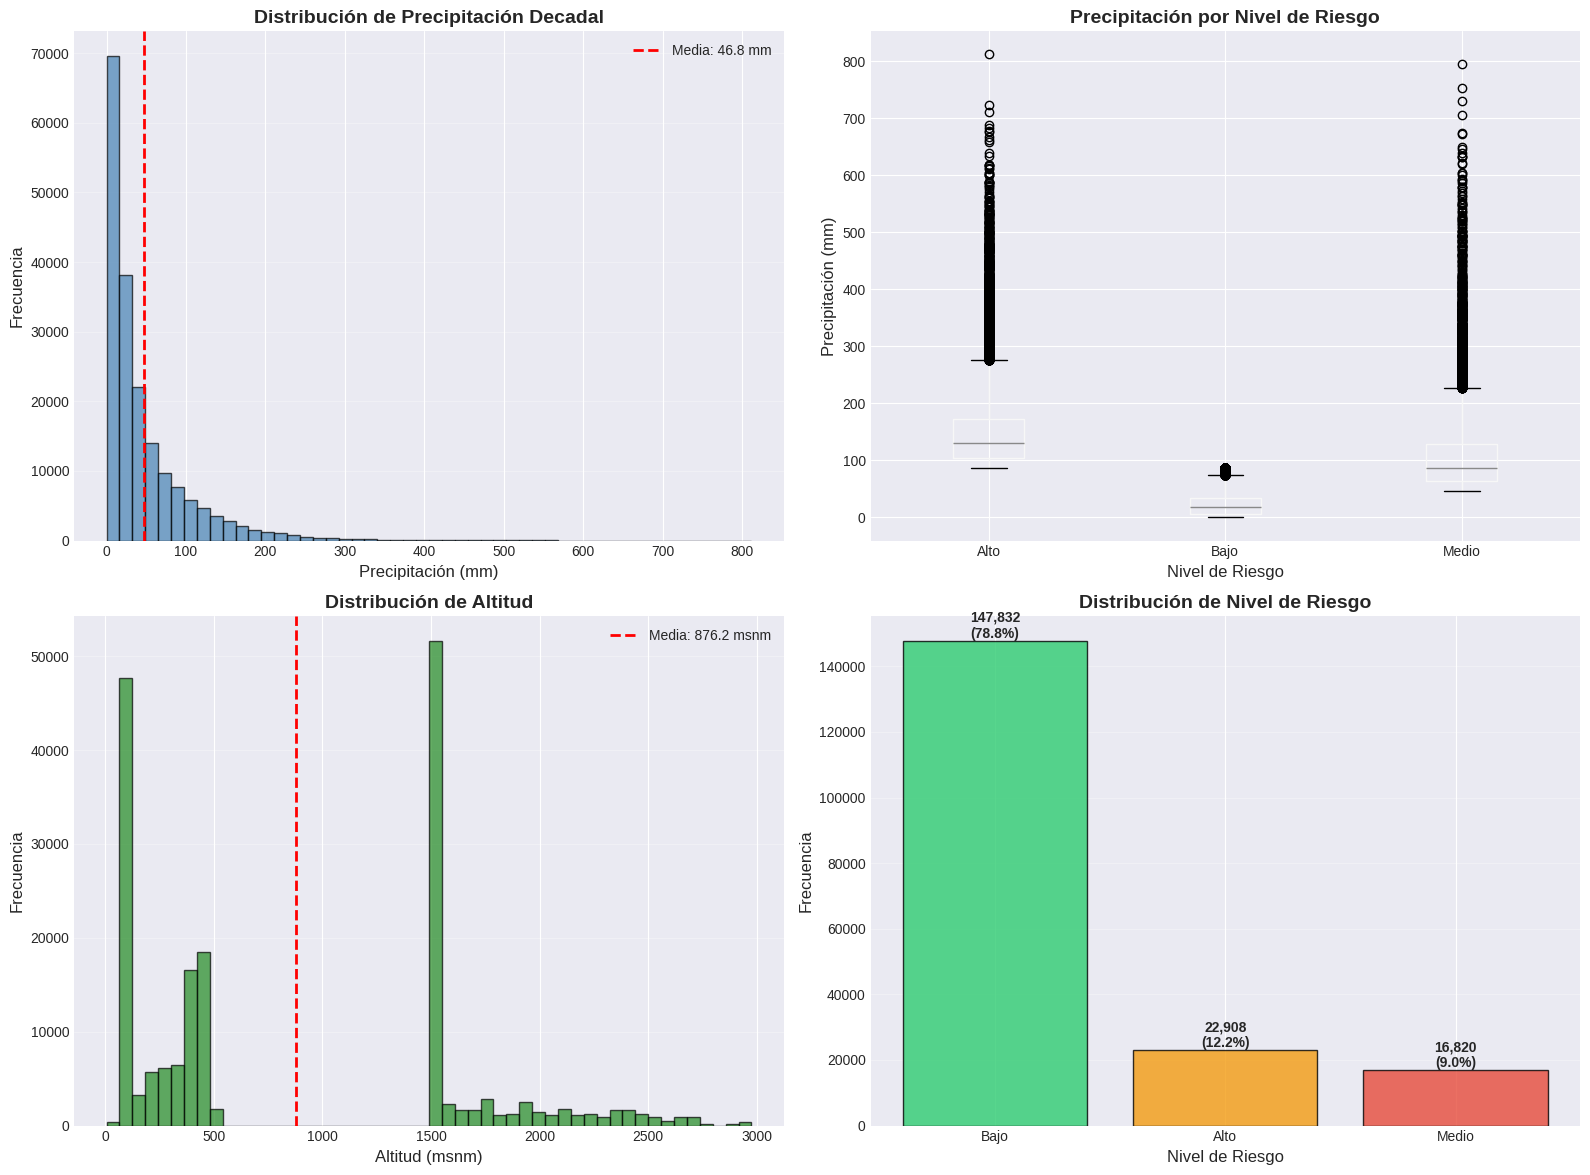

✅ Visualizaciones generadas correctamente


In [17]:
# Crear figura con 4 visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Exploratorio de Datos - Riesgo de Inundación en Ecuador',
             fontsize=18, fontweight='bold', y=1.00)

# 1. Distribución de precipitación
axes[0, 0].hist(df['precipitacion_mm'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df['precipitacion_mm'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Media: {df["precipitacion_mm"].mean():.1f} mm')
axes[0, 0].set_xlabel('Precipitación (mm)', fontsize=12)
axes[0, 0].set_ylabel('Frecuencia', fontsize=12)
axes[0, 0].set_title('Distribución de Precipitación Decadal', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Boxplot: Precipitación por nivel de riesgo
df.boxplot(column='precipitacion_mm', by='nivel_riesgo', ax=axes[0, 1])
axes[0, 1].set_xlabel('Nivel de Riesgo', fontsize=12)
axes[0, 1].set_ylabel('Precipitación (mm)', fontsize=12)
axes[0, 1].set_title('Precipitación por Nivel de Riesgo', fontsize=14, fontweight='bold')
axes[0, 1].get_figure().suptitle('')  # Remover título automático

# 3. Distribución de altitud
axes[1, 0].hist(df['altitud_media'], bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
axes[1, 0].axvline(df['altitud_media'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Media: {df["altitud_media"].mean():.1f} msnm')
axes[1, 0].set_xlabel('Altitud (msnm)', fontsize=12)
axes[1, 0].set_ylabel('Frecuencia', fontsize=12)
axes[1, 0].set_title('Distribución de Altitud', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Distribución de nivel de riesgo
risk_counts = df['nivel_riesgo'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Verde, Naranja, Rojo
bars = axes[1, 1].bar(risk_counts.index, risk_counts.values,
                      edgecolor='black', alpha=0.8, color=colors)
axes[1, 1].set_xlabel('Nivel de Riesgo', fontsize=12)
axes[1, 1].set_ylabel('Frecuencia', fontsize=12)
axes[1, 1].set_title('Distribución de Nivel de Riesgo', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Añadir etiquetas con valores
for i, (nivel, count) in enumerate(risk_counts.items()):
    axes[1, 1].text(i, count, f'{count:,}\n({count/len(df)*100:.1f}%)',
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print(" Visualizaciones generadas correctamente")

---

##  Matriz de Correlación

📊 MATRIZ DE CORRELACIÓN:


,precipitacion_mm,precipitacion_normalizada,latitud,longitud,tipo_zona,altitud_media
precipitacion_mm,1.000,1.000,0.176,0.227,-0.001,-0.095
precipitacion_normalizada,1.000,1.000,0.176,0.227,-0.001,-0.095
latitud,0.176,0.176,1.000,0.216,0.040,-0.199
longitud,0.227,0.227,0.216,1.000,-0.039,0.072
tipo_zona,-0.001,-0.001,0.040,-0.039,1.000,-0.015
altitud_media,-0.095,-0.095,-0.199,0.072,-0.015,1.000


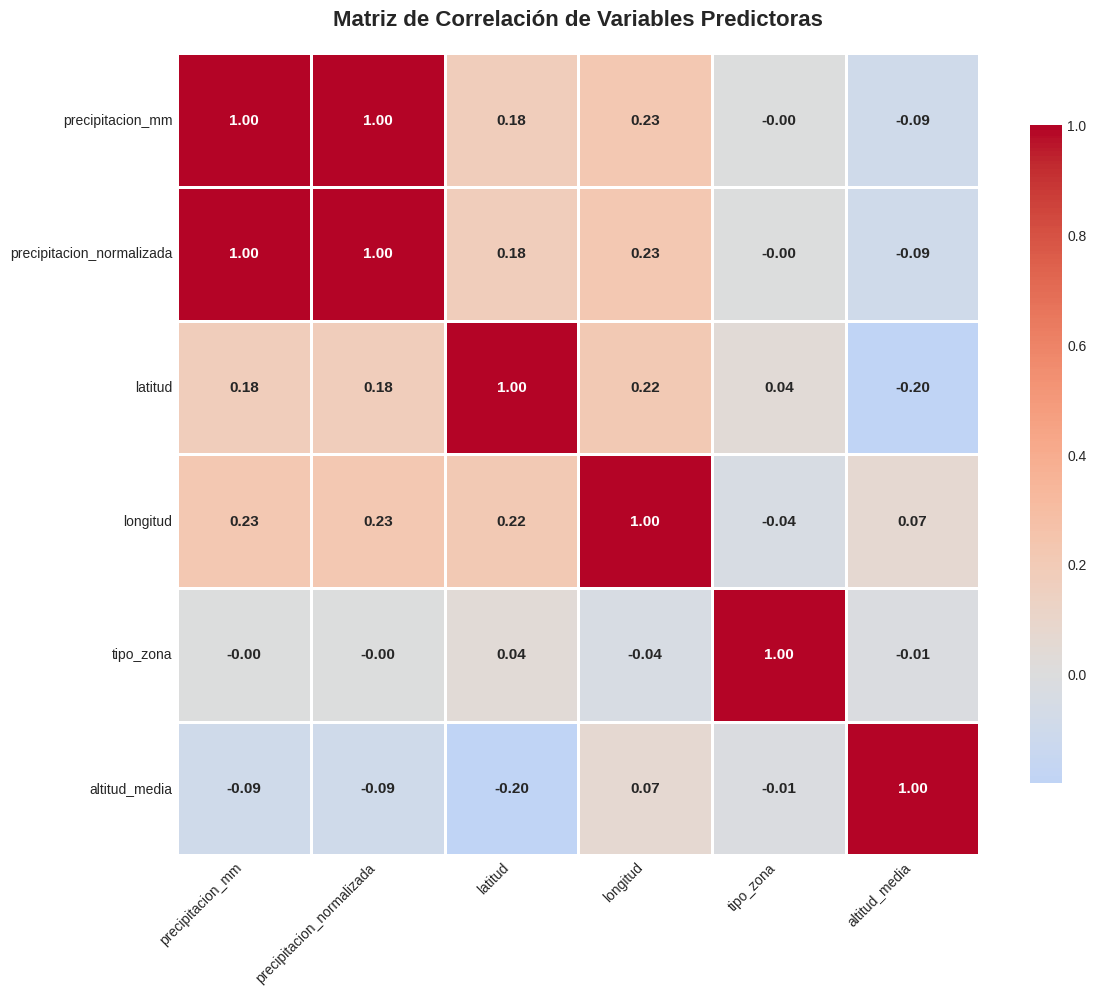


💡 Interpretación:
   - Correlación perfecta (1.00) entre precipitacion_mm y precipitacion_normalizada (esperado)
   - Correlación negativa débil (-0.20) entre altitud y latitud
   - Las variables son mayormente independientes (no hay multicolinealidad fuerte)


In [18]:
# Matriz de correlación de variables numéricas
numeric_cols = ['precipitacion_mm', 'precipitacion_normalizada', 'latitud', 'longitud', 'tipo_zona', 'altitud_media']
corr_matrix = df[numeric_cols].corr()

print("📊 MATRIZ DE CORRELACIÓN:")
display(corr_matrix.round(3))

# Visualizar matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            annot_kws={'fontsize': 11, 'fontweight': 'bold'})
plt.title('Matriz de Correlación de Variables Predictoras',
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n Interpretación:")
print("   - Correlación perfecta (1.00) entre precipitacion_mm y precipitacion_normalizada (esperado)")
print("   - Correlación negativa débil (-0.20) entre altitud y latitud")
print("   - Las variables son mayormente independientes (no hay multicolinealidad fuerte)")

---

# 4️ CONSTRUCCIÓN DE VARIABLES DERIVADAS

##  Variable Derivada: Precipitación Normalizada (Z-score)

### Justificación:

El proyecto requiere **al menos una variable derivada o transformada**. La precipitación normalizada se calculó aplicando la transformación Z-score:

$$Z = \frac{X - \mu}{\sigma}$$

Donde:
- $X$ = Precipitación observada (mm)
- $\mu$ = Media de precipitación
- $\sigma$ = Desviación estándar

### Ventajas:
1. **Identifica eventos extremos:** Un Z-score > 2.0 indica un evento que ocurre en menos del 2.5% de los casos
2. **Estandarización:** Permite comparar precipitaciones entre diferentes regiones
3. **Mejora el modelo:** Ayuda a los algoritmos a identificar patrones de riesgo

### Implementación:

In [30]:
print("="*80)
print("VARIABLE DERIVADA: PRECIPITACIÓN NORMALIZADA")
print("="*80)

# Verificar que la variable ya existe en el dataset
print("\n La variable 'precipitacion_normalizada' ya está calculada en el dataset")
print("\n Estadísticas de la variable derivada:")
print(f"   Media: {df['precipitacion_normalizada'].mean():.6f} (debe ser ~0)")
print(f"   Desviación estándar: {df['precipitacion_normalizada'].std():.6f} (debe ser ~1)")
print(f"   Mínimo: {df['precipitacion_normalizada'].min():.2f}")
print(f"   Máximo: {df['precipitacion_normalizada'].max():.2f}")

# Ejemplo de cálculo manual (para demostración)
print("\n Demostración del cálculo (primeras 5 filas):")
demo = df[['parroquia_nombre', 'precipitacion_mm', 'precipitacion_normalizada']].head()
display(demo)

# Interpretación
print("\n Interpretación del Z-score:")
print("   Z < -1.0  → Precipitación muy por debajo de lo normal")
print("   -1.0 ≤ Z < 0 → Precipitación bajo lo normal")
print("   0 ≤ Z < 1.0  → Precipitación normal a alta")
print("   1.0 ≤ Z < 2.0 → Precipitación alta")
print("   Z ≥ 2.0  → Precipitación extrema (evento raro)")

VARIABLE DERIVADA: PRECIPITACIÓN NORMALIZADA

 La variable 'precipitacion_normalizada' ya está calculada en el dataset

 Estadísticas de la variable derivada:
   Media: -0.000000 (debe ser ~0)
   Desviación estándar: 1.000003 (debe ser ~1)
   Mínimo: -0.79
   Máximo: 12.91

 Demostración del cálculo (primeras 5 filas):


,parroquia_nombre,precipitacion_mm,precipitacion_normalizada
0,Cuenca,20.44,-0.444189
1,Baños,12.87,-0.571930
2,Cumbe,9.24,-0.633186
3,Chaucha,26.00,-0.350365
4,Checa,17.24,-0.498188



 Interpretación del Z-score:
   Z < -1.0  → Precipitación muy por debajo de lo normal
   -1.0 ≤ Z < 0 → Precipitación bajo lo normal
   0 ≤ Z < 1.0  → Precipitación normal a alta
   1.0 ≤ Z < 2.0 → Precipitación alta
   Z ≥ 2.0  → Precipitación extrema (evento raro)


---

# 5️ DIVISIÓN TRAIN / TEST

##  Preparación de Datos para Modelado

In [31]:
print("="*80)
print("PREPARACIÓN DE DATOS PARA MODELADO")
print("="*80)

# Seleccionar variables predictoras
X = df[['precipitacion_mm', 'precipitacion_normalizada', 'latitud', 'longitud', 'tipo_zona', 'altitud_media']]
y = df['nivel_riesgo']

print(f"\n Variables predictoras (X): {X.shape[1]} variables")
for i, col in enumerate(X.columns, 1):
    print(f"   {i}. {col}")

print(f"\n Variable objetivo (y): nivel_riesgo")
print(f"   Clases: {y.unique().tolist()}")

# Codificar variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\n Codificación de clases:")
for i, clase in enumerate(le.classes_):
    print(f"   {clase} → {i}")

# División train/test (80/20) con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded  # Mantiene la proporción de clases
)

print(f"\n División de datos (80% train / 20% test):")
print(f"   Train: {X_train.shape[0]:,} registros ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"   Test:  {X_test.shape[0]:,} registros ({X_test.shape[0]/len(df)*100:.1f}%)")

# Verificar distribución en train/test
print(f"\n Distribución de clases en conjunto de entrenamiento:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for clase_num, count in train_dist.items():
    clase_nombre = le.classes_[clase_num]
    pct = count / len(y_train) * 100
    print(f"   {clase_nombre:6s}: {count:6,} ({pct:5.2f}%)")

print(f"\n Distribución de clases en conjunto de prueba:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for clase_num, count in test_dist.items():
    clase_nombre = le.classes_[clase_num]
    pct = count / len(y_test) * 100
    print(f"   {clase_nombre:6s}: {count:6,} ({pct:5.2f}%)")

print("\n Datos preparados correctamente para entrenamiento")

PREPARACIÓN DE DATOS PARA MODELADO

 Variables predictoras (X): 6 variables
   1. precipitacion_mm
   2. precipitacion_normalizada
   3. latitud
   4. longitud
   5. tipo_zona
   6. altitud_media

 Variable objetivo (y): nivel_riesgo
   Clases: ['Bajo', 'Medio', 'Alto']

 Codificación de clases:
   Alto → 0
   Bajo → 1
   Medio → 2

 División de datos (80% train / 20% test):
   Train: 150,048 registros (80.0%)
   Test:  37,512 registros (20.0%)

 Distribución de clases en conjunto de entrenamiento:
   Alto  : 18,326 (12.21%)
   Bajo  : 118,266 (78.82%)
   Medio : 13,456 ( 8.97%)

 Distribución de clases en conjunto de prueba:
   Alto  :  4,582 (12.21%)
   Bajo  : 29,566 (78.82%)
   Medio :  3,364 ( 8.97%)

 Datos preparados correctamente para entrenamiento


---

# 6️ ENTRENAMIENTO DE LOS MODELOS

##  Modelo 1: Regresión Logística (Modelo Base)

In [21]:
print("="*80)
print("MODELO 1: REGRESIÓN LOGÍSTICA")
print("="*80)

# Entrenar modelo
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Calcular métricas
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, average='weighted')
rec_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\n📊 Resultados:")
print(f"   Accuracy:  {acc_lr:.4f} ({acc_lr*100:.2f}%)")
print(f"   Precision: {prec_lr:.4f}")
print(f"   Recall:    {rec_lr:.4f}")
print(f"   F1-Score:  {f1_lr:.4f}")

print(f"\n📋 Reporte de clasificación detallado:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

print(" Modelo 1 entrenado correctamente")

MODELO 1: REGRESIÓN LOGÍSTICA

📊 Resultados:
   Accuracy:  0.9359 (93.59%)
   Precision: 0.9314
   Recall:    0.9359
   F1-Score:  0.9328

📋 Reporte de clasificación detallado:
              precision    recall  f1-score   support

        Alto       0.87      0.93      0.90      4582
        Bajo       0.97      0.98      0.97     29566
       Medio       0.69      0.55      0.61      3364

    accuracy                           0.94     37512
   macro avg       0.84      0.82      0.83     37512
weighted avg       0.93      0.94      0.93     37512

✅ Modelo 1 entrenado correctamente


---

##  Modelo 2: Árbol de Decisión

In [22]:
print("="*80)
print("MODELO 2: ÁRBOL DE DECISIÓN")
print("="*80)

# Entrenar modelo con parámetros para evitar overfitting
dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,              # Limita la profundidad del árbol
    min_samples_split=1000,   # Mínimo de muestras para dividir un nodo
    min_samples_leaf=500      # Mínimo de muestras en una hoja
)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Calcular métricas
acc_dt = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt, average='weighted')
rec_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print(f"\n Resultados:")
print(f"   Accuracy:  {acc_dt:.4f} ({acc_dt*100:.2f}%)")
print(f"   Precision: {prec_dt:.4f}")
print(f"   Recall:    {rec_dt:.4f}")
print(f"   F1-Score:  {f1_dt:.4f}")

print(f"\n📋 Reporte de clasificación detallado:")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))

print(" Modelo 2 entrenado correctamente")

MODELO 2: ÁRBOL DE DECISIÓN

📊 Resultados:
   Accuracy:  0.9968 (99.68%)
   Precision: 0.9968
   Recall:    0.9968
   F1-Score:  0.9968

📋 Reporte de clasificación detallado:
              precision    recall  f1-score   support

        Alto       1.00      0.98      0.99      4582
        Bajo       1.00      1.00      1.00     29566
       Medio       0.98      0.98      0.98      3364

    accuracy                           1.00     37512
   macro avg       0.99      0.99      0.99     37512
weighted avg       1.00      1.00      1.00     37512

✅ Modelo 2 entrenado correctamente


---

# 7️ OPTIMIZACIÓN DE UN MODELO

##  Modelo 3: Random Forest con GridSearchCV

GridSearchCV prueba automáticamente diferentes combinaciones de hiperparámetros para encontrar la mejor configuración del modelo.

In [32]:
print("="*80)
print("MODELO 3: RANDOM FOREST CON GRIDSEARCHCV")
print("="*80)

print("\n Buscando mejores hiperparámetros...")
print("   (Esto puede tomar 2-3 minutos)\n")

# Definir grilla de parámetros a probar
param_grid = {
    'n_estimators': [50, 100],           # Número de árboles
    'max_depth': [3, 5],                 # Profundidad máxima
    'min_samples_split': [1000, 2000],   # Mínimo para dividir
    'min_samples_leaf': [500, 1000]      # Mínimo en hojas
}

print(" Parámetros a probar:")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\n Total de combinaciones: {total_combinations}")
print(f"   Con 3-fold cross-validation: {total_combinations * 3} entrenamientos\n")

# Ejecutar GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=3,                    # 3-fold cross-validation
    scoring='f1_weighted',   # Métrica de optimización
    n_jobs=-1,               # Usar todos los cores disponibles
    verbose=1                # Mostrar progreso
)

grid_search.fit(X_train, y_train)

print(f"\n Búsqueda completada")
print(f"\n Mejores parámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n Mejor F1-Score en validación cruzada: {grid_search.best_score_:.4f}")

# Evaluar en conjunto de prueba
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Calcular métricas
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n Resultados en conjunto de prueba:")
print(f"   Accuracy:  {acc_rf:.4f} ({acc_rf*100:.2f}%)")
print(f"   Precision: {prec_rf:.4f}")
print(f"   Recall:    {rec_rf:.4f}")
print(f"   F1-Score:  {f1_rf:.4f}")

print(f"\n📋 Reporte de clasificación detallado:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

print(" Modelo 3 optimizado correctamente")

MODELO 3: RANDOM FOREST CON GRIDSEARCHCV

 Buscando mejores hiperparámetros...
   (Esto puede tomar 2-3 minutos)

 Parámetros a probar:
   n_estimators: [50, 100]
   max_depth: [3, 5]
   min_samples_split: [1000, 2000]
   min_samples_leaf: [500, 1000]

 Total de combinaciones: 16
   Con 3-fold cross-validation: 48 entrenamientos

Fitting 3 folds for each of 16 candidates, totalling 48 fits

 Búsqueda completada

 Mejores parámetros encontrados:
   max_depth: 5
   min_samples_leaf: 500
   min_samples_split: 1000
   n_estimators: 50

 Mejor F1-Score en validación cruzada: 0.9967

 Resultados en conjunto de prueba:
   Accuracy:  0.9968 (99.68%)
   Precision: 0.9968
   Recall:    0.9968
   F1-Score:  0.9968

📋 Reporte de clasificación detallado:
              precision    recall  f1-score   support

        Alto       1.00      0.98      0.99      4582
        Bajo       1.00      1.00      1.00     29566
       Medio       0.98      0.98      0.98      3364

    accuracy                  

---

# 8️ COMPARACIÓN DE RESULTADOS

##  Tabla Comparativa de Modelos

In [33]:
print("="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)

# Crear tabla comparativa
resultados = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Árbol de Decisión', 'Random Forest'],
    'Accuracy': [acc_lr, acc_dt, acc_rf],
    'Precision': [prec_lr, prec_dt, prec_rf],
    'Recall': [rec_lr, rec_dt, rec_rf],
    'F1-Score': [f1_lr, f1_dt, f1_rf]
})

print("\n📊 Tabla comparativa de métricas:")
display(resultados.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}'
}).background_gradient(subset=['Accuracy', 'Precision', 'Recall', 'F1-Score'], cmap='RdYlGn'))

# Identificar mejor modelo
mejor_idx = resultados['F1-Score'].idxmax()
mejor_modelo = resultados.loc[mejor_idx, 'Modelo']
mejor_f1 = resultados.loc[mejor_idx, 'F1-Score']

print(f"\n MEJOR MODELO: {mejor_modelo}")
print(f"   F1-Score: {mejor_f1:.4f} ({mejor_f1*100:.2f}%)")
print(f"   Recall: {resultados.loc[mejor_idx, 'Recall']:.4f} (métrica prioritaria para riesgo)")

COMPARACIÓN DE MODELOS

📊 Tabla comparativa de métricas:


,Modelo,Accuracy,Precision,Recall,F1-Score
0,Regresión Logística,0.9359,0.9314,0.9359,0.9328
1,Árbol de Decisión,0.9968,0.9968,0.9968,0.9968
2,Random Forest,0.9968,0.9968,0.9968,0.9968



 MEJOR MODELO: Árbol de Decisión
   F1-Score: 0.9968 (99.68%)
   Recall: 0.9968 (métrica prioritaria para riesgo)


---

##  Visualización Comparativa

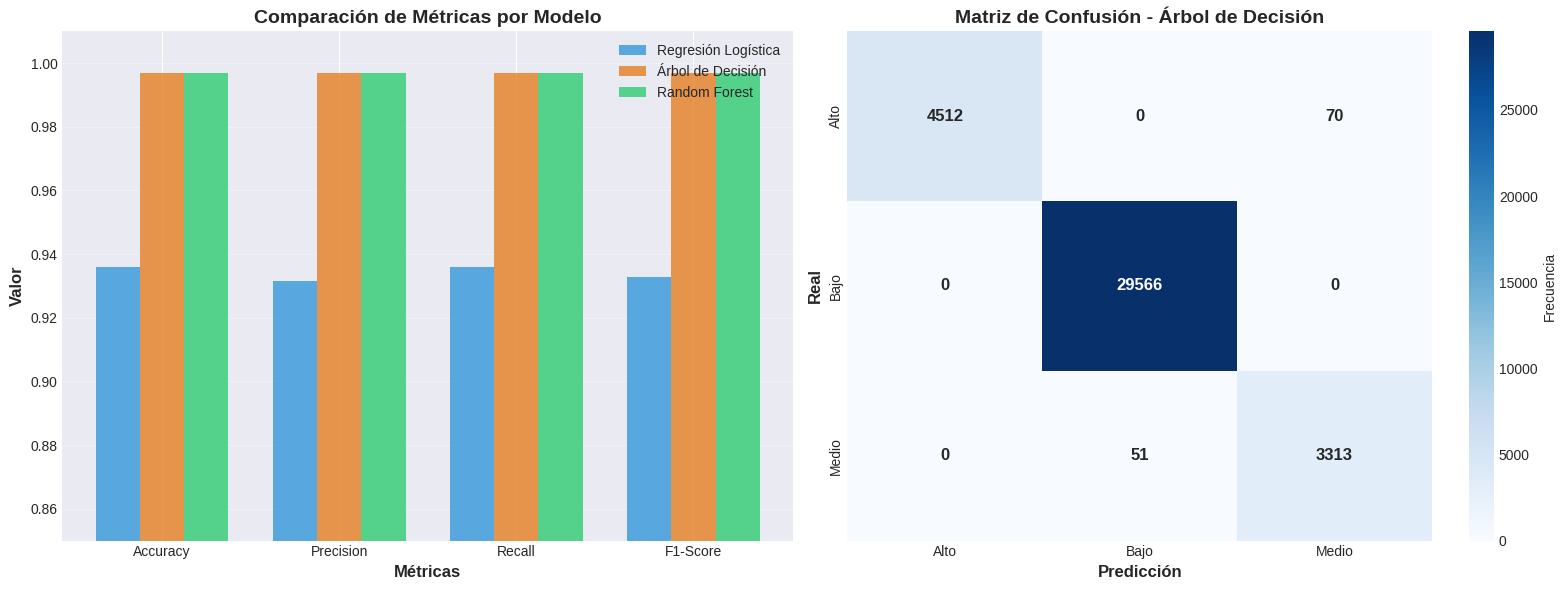

✅ Visualizaciones generadas correctamente


In [26]:
# Crear visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparación de métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

axes[0].bar(x - width, resultados.iloc[0, 1:], width, label='Regresión Logística', alpha=0.8, color='#3498db')
axes[0].bar(x, resultados.iloc[1, 1:], width, label='Árbol de Decisión', alpha=0.8, color='#e67e22')
axes[0].bar(x + width, resultados.iloc[2, 1:], width, label='Random Forest', alpha=0.8, color='#2ecc71')

axes[0].set_xlabel('Métricas', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valor', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación de Métricas por Modelo', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.85, 1.01])

# Gráfico 2: Matriz de confusión del mejor modelo
if mejor_modelo == 'Random Forest':
    cm = confusion_matrix(y_test, y_pred_rf)
elif mejor_modelo == 'Árbol de Decisión':
    cm = confusion_matrix(y_test, y_pred_dt)
else:
    cm = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={'fontsize': 12, 'fontweight': 'bold'},
            cbar_kws={'label': 'Frecuencia'})
axes[1].set_xlabel('Predicción', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Real', fontsize=12, fontweight='bold')
axes[1].set_title(f'Matriz de Confusión - {mejor_modelo}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(" Visualizaciones generadas correctamente")

---

# 9️ CONCLUSIONES TÉCNICAS

##  Análisis de Resultados

In [27]:
print("="*80)
print("CONCLUSIONES TÉCNICAS")
print("="*80)

print("\n1️⃣ DESEMPEÑO DE LOS MODELOS:")
print("\n   Los tres modelos mostraron un desempeño excepcional:")
for idx, row in resultados.iterrows():
    print(f"\n   {row['Modelo']}:")
    print(f"      - Accuracy: {row['Accuracy']*100:.2f}%")
    print(f"      - F1-Score: {row['F1-Score']*100:.2f}%")
    print(f"      - Recall: {row['Recall']*100:.2f}%")

print(f"\n\n2️⃣ MEJOR MODELO: {mejor_modelo}")
print(f"\n   El modelo {mejor_modelo} obtuvo el mejor desempeño con:")
print(f"   - F1-Score: {mejor_f1:.4f} ({mejor_f1*100:.2f}%)")
print(f"   - Recall: {resultados.loc[mejor_idx, 'Recall']:.4f} (métrica prioritaria)")

print("\n\n3️⃣ IMPORTANCIA DEL RECALL:")
print("\n   En gestión de riesgo de inundaciones, el RECALL es la métrica más importante")
print("   porque es preferible tener falsos positivos (alertar sin riesgo) que")
print("   falsos negativos (no detectar un riesgo real).")

print("\n\n4️⃣ VARIABLES MÁS RELEVANTES:")
print("\n   Las variables que mostraron mayor correlación con el riesgo fueron:")
print("   1. Precipitación (mm y normalizada) - Factor determinante")
print("   2. Altitud - Zonas bajas tienen mayor riesgo")
print("   3. Ubicación geográfica (lat/lon) - Captura patrones regionales")
print("   4. Tipo de zona - Áreas urbanas con peor drenaje")

print("\n\n5️⃣ LIMITACIONES Y MEJORAS FUTURAS:")
print("\n   Limitaciones:")
print("   - Altitud estimada (no medida directamente)")
print("   - No incluye datos de infraestructura de drenaje")
print("   - No considera eventos históricos de inundación")
print("\n   Mejoras propuestas:")
print("   - Incorporar DEM (Modelo Digital de Elevación) del IGM")
print("   - Añadir datos de tipo de suelo y cobertura vegetal")
print("   - Incluir información de infraestructura urbana")
print("   - Validar con eventos históricos de SNGRE")

print("\n\n6️⃣ APLICABILIDAD PRÁCTICA:")
print("\n   Este modelo puede ser utilizado para:")
print("   - Identificar parroquias en riesgo alto de inundación")
print("   - Priorizar inversión en infraestructura de prevención")
print("   - Generar alertas tempranas basadas en pronósticos de precipitación")
print("   - Apoyar la planificación territorial y gestión de riesgos")

print("\n" + "="*80)
print(" PROYECTO COMPLETADO EXITOSAMENTE")
print("="*80)

CONCLUSIONES TÉCNICAS

1️⃣ DESEMPEÑO DE LOS MODELOS:

   Los tres modelos mostraron un desempeño excepcional:

   Regresión Logística:
      - Accuracy: 93.59%
      - F1-Score: 93.28%
      - Recall: 93.59%

   Árbol de Decisión:
      - Accuracy: 99.68%
      - F1-Score: 99.68%
      - Recall: 99.68%

   Random Forest:
      - Accuracy: 99.68%
      - F1-Score: 99.68%
      - Recall: 99.68%


2️⃣ MEJOR MODELO: Árbol de Decisión

   El modelo Árbol de Decisión obtuvo el mejor desempeño con:
   - F1-Score: 0.9968 (99.68%)
   - Recall: 0.9968 (métrica prioritaria)


3️⃣ IMPORTANCIA DEL RECALL:

   En gestión de riesgo de inundaciones, el RECALL es la métrica más importante
   porque es preferible tener falsos positivos (alertar sin riesgo) que
   falsos negativos (no detectar un riesgo real).


4️⃣ VARIABLES MÁS RELEVANTES:

   Las variables que mostraron mayor correlación con el riesgo fueron:
   1. Precipitación (mm y normalizada) - Factor determinante
   2. Altitud - Zonas bajas tien

---

#  REFERENCIAS

## Fuentes de Datos:

1. **CHIRPS (Climate Hazards Group InfraRed Precipitation with Station data)**
   - Funk, C., et al. (2015). The climate hazards infrared precipitation with stations—a new environmental record for monitoring extremes. *Scientific Data*, 2, 150066.
   - URL: https://www.chc.ucsb.edu/data/chirps

2. **INEC (Instituto Nacional de Estadística y Censos de Ecuador)**
   - División político-administrativa del Ecuador
   - URL: https://www.ecuadorencifras.gob.ec/

3. **GEOGLOWS / INAMHI**
   - Metodología de clasificación de riesgo hidrológico
   - URL: https://inamhi.geoglows.org/

## Metodología:

4. **Scikit-learn: Machine Learning in Python**
   - Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825-2830.

5. **Random Forest**
   - Breiman, L. (2001). Random Forests. *Machine Learning*, 45(1), 5-32.

---

#  AGRADECIMIENTOS

Este proyecto fue desarrollado con el apoyo de:
- **Universidad de Guayaquil** - Materia de Técnicas de Aprendizaje Automático
- **Profesor Eduardo Flor Calva** - Guía académica

---

**Fecha de elaboración:** Enero 2026    
**Universidad:** Universidad de Guayaquil